In [27]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS

# Problem 2: Reed Frogs

The common reed frog is a species of frogs found naturally in many parts of Africa. 

In this assignment, we check, evaluate and compare three models which rely on tank density, frog size and predation to predict frog survivability. ![common Reed Frog](https://upload.wikimedia.org/wikipedia/commons/3/36/Tree_frog_congo.jpg)	
# This file was automatically generated by WSL. To stop automatic generation of this file, add the following entry to /etc/wsl.conf:
# [network]
# generateResolvConf = false
nameserver 8.8.8.8

In [28]:
df = pd.read_csv('../input/04reedfrogs.csv')


In [29]:
# categorize values
df["cdensity"] = pd.factorize(df.density)[0]
df["cpred"] = pd.factorize(df.pred)[0]
df["csize"] = pd.factorize(df["size"])[0]
df.head(10)

,density,pred,size,surv,propsurv,cdensity,cpred,csize
0,10,no,big,9,0.9,0,0,0
1,10,no,big,10,1.0,0,0,0
2,10,no,big,7,0.7,0,0,0
3,10,no,big,10,1.0,0,0,0
4,10,no,small,9,0.9,0,0,1
5,10,no,small,9,0.9,0,0,1
6,10,no,small,10,1.0,0,0,1
7,10,no,small,9,0.9,0,0,1
8,10,pred,big,4,0.4,0,1,0
9,10,pred,big,9,0.9,0,1,0


## Effect of Predation
It is easily visible that predation has a large effect on the frogs' survivability:

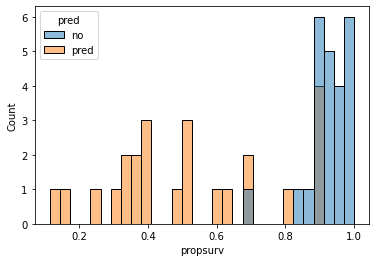

In [30]:
sns.histplot(data=df, x="propsurv", hue="pred", bins=30);

## Defining the Models
`reedfrogs_lin` is the generalized linear regression model. `reedfrogs_hier5` is the hierarchical model from lecture 5 based on population only. `reedfrogs_hier6` is the hierarchical model from lecture 6 based on population size and predation.

In [31]:
def reedfrogs_hier5(density, survival):
    N = len(density)
    sigma = numpyro.sample("sigma", dist.Exponential(1.))
    alpha_0 = numpyro.sample("alpha_0", dist.Normal(0., 1.5))
    alpha_t = numpyro.sample("alpha_t", dist.MultivariateNormal(np.full([N], alpha_0), sigma * np.eye(N)))

    for i in numpyro.plate('data_loop', len(density)):
        alpha = alpha_t[i]
        p = np.sigmoid(alpha)
        numpyro.sample(f"survival_{i}", dist.Binomial(density[i], p), obs=survival[i])

In [32]:
# todo: why is this so slow?
nuts_kernel = NUTS(reedfrogs_hier5, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=500)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, df.density, df.surv, extra_fields=('potential_energy',))
mcmc.get_samples()

TypeError: 'plate' object is not iterable

In [36]:
dist.Normal(tensor([0., 0.]), tensor([1., 0.001])).sample()

tensor([-3.9294e-01, -9.2849e-05])